In [1]:
import torch
from torch import nn, optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class Conv_Block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(Conv_Block, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [4]:
class Inception_Block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_Block, self).__init__()
    self.branch1 = Conv_Block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
        Conv_Block(in_channels, red_3x3, kernel_size=1),
        Conv_Block(red_3x3, out_3x3, kernel_size=3, padding=1)
    )

    self.branch3 = nn.Sequential(
        Conv_Block(in_channels, red_5x5, kernel_size=1),
        Conv_Block(red_5x5, out_5x5, kernel_size=5, padding=2)
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        Conv_Block(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self, x):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

In [5]:
class GoogLeNet(nn.Module):
  def __init__(self, in_channels=3, num_classes=1000):
    super(GoogLeNet, self).__init__()
    self.conv1 = Conv_Block(in_channels, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = Conv_Block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_Block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_Block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_Block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_Block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_Block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_Block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_Block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_Block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_Block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, 1000)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)
    return x

In [6]:
model = GoogLeNet()
x = torch.randn(3, 3, 224, 224)
print(model(x).shape)

torch.Size([3, 1000])


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
tx = transforms.Compose(
    [transforms.Resize((224, 224)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

BATCH_SIZE = 32

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=tx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validate_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=tx)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
from matplotlib import pyplot as plt
import numpy as np
import torchvision
from datetime import datetime

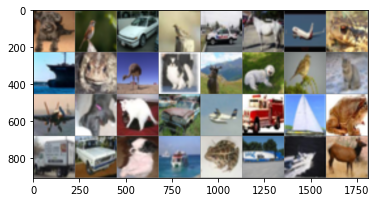

  dog  bird   car  bird   car horse plane  frog  ship  frog  bird   dog  deer   dog  bird   cat plane   dog   cat   car plane truck  ship  frog truck   car   dog  ship  frog truck  ship  deer


In [10]:
def imshow(img):
  img = img / 2 + 0.5  # denormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

data_iter = iter(train_loader)
img, labels = data_iter.next()

imshow(torchvision.utils.make_grid(img))
print(' '.join('%5s' % classes[labels[i]] for i in range(BATCH_SIZE)))

In [11]:
model = GoogLeNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
print(f'{datetime.now().time().replace(microsecond=0)} --- Start Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 100 == 99:  # print every 100 mini-batches
      print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch: {epoch + 1}\t'
            f'Batch: {i + 1}\t'
            f'Loss: {running_loss / 100:.3f}')
      running_loss = 0.0

18:56:56 --- Start Training
18:57:11 --- Epoch: 1	Batch: 100	Loss: 2.172
18:57:25 --- Epoch: 1	Batch: 200	Loss: 1.790
18:57:40 --- Epoch: 1	Batch: 300	Loss: 1.727
18:57:54 --- Epoch: 1	Batch: 400	Loss: 1.657
18:58:08 --- Epoch: 1	Batch: 500	Loss: 1.576
18:58:23 --- Epoch: 1	Batch: 600	Loss: 1.567
18:58:38 --- Epoch: 1	Batch: 700	Loss: 1.481
18:58:52 --- Epoch: 1	Batch: 800	Loss: 1.471
18:59:07 --- Epoch: 1	Batch: 900	Loss: 1.404
18:59:22 --- Epoch: 1	Batch: 1000	Loss: 1.353
18:59:37 --- Epoch: 1	Batch: 1100	Loss: 1.300
18:59:52 --- Epoch: 1	Batch: 1200	Loss: 1.298
19:00:07 --- Epoch: 1	Batch: 1300	Loss: 1.260
19:00:22 --- Epoch: 1	Batch: 1400	Loss: 1.184
19:00:37 --- Epoch: 1	Batch: 1500	Loss: 1.166
19:01:02 --- Epoch: 2	Batch: 100	Loss: 1.114
19:01:17 --- Epoch: 2	Batch: 200	Loss: 1.048
19:01:32 --- Epoch: 2	Batch: 300	Loss: 1.086
19:01:47 --- Epoch: 2	Batch: 400	Loss: 1.056
19:02:02 --- Epoch: 2	Batch: 500	Loss: 1.027
19:02:17 --- Epoch: 2	Batch: 600	Loss: 1.026
19:02:32 --- Epoch: 2

Check for accuracy of the model from validation set.

In [12]:
correct = 0
total = 0

with torch.no_grad():
  for data in validate_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'{correct} correct predictions out of {total}. Accuracy: {100 * correct / total}')

8076 correct predictions out of 10000. Accuracy: 80.76


Compare accuracy by class.

In [13]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

with torch.no_grad():
  for data in validate_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(len(classes)):
  print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]}')

Accuracy of plane : 88.7
Accuracy of car : 88.9
Accuracy of bird : 69.4
Accuracy of cat : 61.0
Accuracy of deer : 84.4
Accuracy of dog : 68.3
Accuracy of frog : 84.6
Accuracy of horse : 88.5
Accuracy of ship : 86.4
Accuracy of truck : 85.5
